In [2]:
from zipfile import ZipFile
import torchvision
import os
from scipy.io import loadmat
from sklearn.model_selection import StratifiedShuffleSplit
import collections
import numpy as np
from torch.utils.data import Dataset,DataLoader
from torchvision.models.segmentation import fcn_resnet50
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable


In [3]:
# # specifying the zip file name
# file_name = "underwater_sem_seg.zip"
# #
# # # opening the zip file in READ mode
# with ZipFile(file_name, 'r') as zip:
#     # printing all the contents of the zip file
#     zip.printdir()

#     # extracting all the files
#     print('Extracting all the files now...')
#     zip.extractall()
#     print('Done!')


In [3]:
# pip install torchvision

In [4]:
# os.listdir("underwater_sem_seg/dataset")

In [4]:
root = "underwater_sem_seg/dataset"

entries = os.listdir(root)
entries.remove("indices_files")
entries.remove('.DS_Store')
print(entries)
folders = [root+"/"+i for i in entries[1:]]
print(folders)
# entries = os.listdir(folders[0])
# print(entries)
images = []
masks = []
imclasses = []
for folder in folders:
    entries = os.listdir(folder)
    for image_data in entries:
#         print(folder+"/"+image_data)
        mat = loadmat(folder+"/"+image_data)
        # print(mat)
        images.append(np.asarray(mat["image_array"]))
        imclasses.append(mat["class"])
        masks.append(np.asarray(mat["mask_array"]))
        # images.append((imclass,image,mask_array))
    # break

print(len(images))
print(images[0].shape)


['dolphin_sem_seg_gt', 'crocodile_sem_seg_gt', 'seal_sem_seg_gt', 'sea_anemone_sem_seg_gt', 'squid_sem_seg_gt', 'turtle_sem_seg_gt', 'sea_urchin_sem_seg_gt', 'penguin_sem_seg_gt', 'whale_sem_seg_gt', 'frog_sem_seg_gt', 'crab_sem_seg_gt', 'otter_sem_seg_gt', 'nettles_sem_seg_gt', 'shark_sem_seg_gt', 'polar_bear_sem_seg_gt', 'shrimp_sem_seg_gt', 'star_fish_sem_seg_gt', 'octopus_sem_seg_gt', 'seahorse_sem_seg_gt', 'stingray_sem_seg_gt', 'nudibranch_sem_seg_gt']
['underwater_sem_seg/dataset/crocodile_sem_seg_gt', 'underwater_sem_seg/dataset/seal_sem_seg_gt', 'underwater_sem_seg/dataset/sea_anemone_sem_seg_gt', 'underwater_sem_seg/dataset/squid_sem_seg_gt', 'underwater_sem_seg/dataset/turtle_sem_seg_gt', 'underwater_sem_seg/dataset/sea_urchin_sem_seg_gt', 'underwater_sem_seg/dataset/penguin_sem_seg_gt', 'underwater_sem_seg/dataset/whale_sem_seg_gt', 'underwater_sem_seg/dataset/frog_sem_seg_gt', 'underwater_sem_seg/dataset/crab_sem_seg_gt', 'underwater_sem_seg/dataset/otter_sem_seg_gt', 'und

In [5]:

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.1)

for train_index, test_index in split.split(images,imclasses):
    print(train_index,test_index)
    images_train = [images[i] for i in train_index]
    classes_train = [imclasses[i] for i in train_index]
    masks_train = [masks[i] for i in train_index]

    images_test = [images[i] for i in test_index]
    classes_test = [imclasses[i] for i in test_index]
    masks_test = [masks[i] for i in test_index]

print(len(images_train),len(images_test))

print(classes_train)
print(classes_test)

[ 47 352 304  29 471 466  65  92 163 430 402  18  99 346 113 539  94 437
 524 291 257 256 118 415  85 242 485 210  15 173  70 408  31 264 262 227
 425   4 177 449 509 519 192 194  62 108 490 300 398 201  54  44 417 135
  41  86 225 289 133 274 309 508   5  75 258 475 502 287 371 176 499 495
 392  21  98 445 188 324 119 427 532 354 214  55 349  60 297 174 536  71
 134 307 507 190 148 522  43 342  84 369 403 480 378 544 284 122   0 147
 191  12 101 248 376 412 129 259 164 361 100 344 168 246 215 462 110  45
 310 233 302 498 457 213 161 456 285 208  25 395 404 420 193 218 528 521
 180 439 448 384 389  28  89 263  42 298 223 353 154  37 183 383 467 477
 451  61 493 491 356 367 232 116 290 241 296 459  91 494  33 418 157 136
 178 117  51  63 150 484 159  76 305 520 399 362 526 343 239 453 127 328
 314 123 416 205 516 286 160 355 441 196  23  27 436 125 283 350 479 385
 151 380  66 537 374 511  34 375 288 476  77 280 295 155 531 333 269 463
 452 465 253 390 460 443 407 245 282 254  13 530 30

In [7]:
class myDataset(Dataset):
    def __init__(self,input_data,mask,transform):
        self.input=input_data
        self.mask = mask
        self.transforms = transform

    def __len__(self):
        return len(self.input)

    def __getitem__(self, index):
        x=self.input[index]
        z=self.mask[index]
#         print(x,z)
        if self.transforms is not None:
            # apply the transformations to both image and its mask
            x = self.transforms(x)
            z = self.transforms(z)
        return x,z

class hyperparam:
    num_classes=31
    num_workers=5
    bs=25
    epochs = 10
    HEIGHT= 256
    WIDTH = 256
# params = {shuffle=True,"batch_size" : hyperparam.bs, "num_workers":num_workers=os.cpu_count() ,"pin_memory" : False}


In [8]:
from torchvision import transforms

transforms = transforms.Compose([transforms.ToPILImage(),transforms.Resize((hyperparam.HEIGHT,hyperparam.WIDTH)),transforms.ToTensor()])
#transforms.Resize((hyperparam.HEIGHT,hyperparam.WIDTH)),transforms.CenterCrop(256),
training_set = myDataset(images_train,masks_train,transforms)
test_set = myDataset(images_test,masks_test,transforms)

train_gen = DataLoader(training_set,shuffle=True,batch_size=hyperparam.bs, pin_memory=False,num_workers=os.cpu_count())
test_gen = DataLoader(test_set,shuffle=False,batch_size=2, pin_memory=False,num_workers=os.cpu_count())

In [25]:
class MyFCN(nn.Module):
    def __init__(self, num_classes, 
                 pretrained=True, 
                 criterion=nn.CrossEntropyLoss(ignore_index=255),
                 network_name='resnet50',
                 training=False):                    
        super(MyFCN, self).__init__()
        
        self.num_classes   = num_classes
        self.criterion     = criterion
        self.backbone_name = network_name
        self.training      = training        
        
        if pretrained:
            net = fcn_resnet50(pretrained=pretrained,                             
                            pretrained_backbone= True)
                
        #self.classifier = nn.Sequential(*[net.classifier[i] for i in range(5)])
        
        self.backbone   = net.backbone
        self.classifier = nn.Sequential(*list(net.classifier.children())[:-1])        
#         self.last_layer = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
#         self.upsample1 = nn.ConvTranspose2d(num_classes, num_classes, (4,4), stride=4)
#         self.upsample2 = nn.ConvTranspose2d(num_classes, num_classes, (2,2), stride=2)
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=1, stride=1, padding=0, dilation=1, output_padding=0)
        self.bn5     = nn.BatchNorm2d(32)
        self.final = nn.Conv2d(32, num_classes, kernel_size=1)
        
        '''if self.training:
            self.aux_classifier = nn.Sequential(*list(net.aux_classifier.children())[:-1])        
            self.aux_last_layer = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
            '''

        
    def forward(self, x):
        
        x = self.backbone(x)
        x = x['out'] # the other key in the ordered dictionary is 'aux'
        #pdb.set_trace()
        x = self.classifier(x)
#         x = self.last_layer(x) 
#         x = self.upsample1(x)
#         x = self.upsample2(x)
        score = self.bn1(x)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.relu(self.deconv2(score))            # size=(2, 256, x.H/4, x.W/4)
        score = self.bn2(score) 
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/2, x.W/2)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.final(score)                    # size=(N, n_class, x.H/1, x.W/1)
#         if self.training:
# #             pdb.set_trace()
# #             main_loss = self.criterion(x, y)
#             return x.max(1)[1], main_loss

#             #aux       = self.aux_classifier(x_tmp)        
#             #aux_loss  = self.criterion(aux, y)
#             #return x.max(1)[1], main_loss, aux_loss
            
#         else:
        return score            


In [26]:
# model = fcn_resnet50(pretrained=False, progress=False,num_classes=31,pretrained_backbone= True)
# model = model.train(True)
# model

model = MyFCN(num_classes = 31)


In [27]:
lossfunc = nn.CrossEntropyLoss()
# lossfunc = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(),lr = 0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.1, patience = 5)


In [28]:
classes = ["crab","crocodile","dolphin","frog","nettles","octopus","otter","penguin","polar_bear","sea_anemone","sea_urchin","seahorse","seal","shark","shrimp","star_fish","stingray","squid","turtle","whale","nudibranch","coral","rock","water","sand","plant","human","iceberg","reef","fish","other"]

sem_class_to_idx = {cls: idx for (idx,cls) in enumerate(classes)}
# sem_class_to_idx

In [ ]:
training_total_loss=[]
training_loss=[]

import torchvision.transforms.functional as F
for epochs in range(hyperparam.epochs):
    training_loss=[]
    model.train(True)
    print("here")
    with torch.set_grad_enabled(True):
        print("here1")
        for batch,labels in train_gen:
#             print("here2")
            batch=batch.float()
            labels=labels.float()
#             print("batch size", batch.size())
#             batch,label=Variable(batch,requires_grad=True),Variable(labels,requires_grad=True)
#             print(batch,label)
            batch = F.normalize(batch,mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
            labels = torch.nn.functional.softmax(labels,dim =1)
            predictions=model(batch)
#             print("predictions" ,predictions)
#             print("predictions size",predictions.size())
#             print("norm_pred",norm_pred.size())
#             np = torch.argmax(predictions.squeeze(),dim=1)
            predictions = predictions.type(torch.FloatTensor)
#             npred = torch.nn.functional.softmax(predictions,dim =1)
#             print("np ", np.size())
            labels = labels.squeeze(1)
            labels = labels.type(torch.LongTensor)
#             print("label size", labels.size())
            pred_loss = lossfunc(predictions,labels) 
#             pred_loss.requires_grad = True
#             print(pred_loss.requires_grad)
            optimizer.zero_grad()
            pred_loss.backward()
            optimizer.step()
#             training_loss.append(pred_loss)
#         print("training_loss",training_loss)
#         print("training_total_loss",training_loss)
        training_total_loss.append(pred_loss)
        print(pred_loss)
        scheduler.step(pred_loss)

here
here1
tensor(3.4632, grad_fn=<NllLoss2DBackward0>)
here
here1


In [ ]:
# print(training_total_loss)

In [14]:
import torchvision.transforms.functional as F
testing_total_loss=[]
testing_loss=[]
model.eval()
print("here")
with torch.set_grad_enabled(False):
    print("here1")
    for batch,labels in test_gen:
#             print("here2")
        batch=batch.float()
        labels=labels.float()
#         labels = ((labels - labels.min()) * (1/(labels.max() - labels.min())*30))
        print("batch size", batch.size())
#             batch,label=Variable(batch,requires_grad=True),Variable(labels,requires_grad=True)
#             print(batch,label)
        batch = F.normalize(batch,mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
        predictions=model(batch)["out"]
#             print("predictions" ,predictions)
#             print("predictions size",predictions.size())
#             print("norm_pred",norm_pred.size())
#         npred = torch.argmax(predictions.squeeze(),dim=1)
        predictions = predictions.type(torch.FloatTensor)
        npred = torch.nn.functional.softmax(predictions,dim =1)
        print("np ", npred.size())
        labels = labels.squeeze(1)
        labels = labels.type(torch.LongTensor)
#             print("label size", labels.size())
        pred_loss = lossfunc(npred,labels) 
        testing_loss.append(pred_loss)
#             print("pred_loss",pred_loss)
#         print("batch[0]",batch[0])
        masks = [
            npred[img_idx,sem_class_to_idx[cls]]
            for img_idx in range(batch.shape[0])
            for cls in classes]
        break


here
here1
batch size torch.Size([2, 3, 256, 256])
np  torch.Size([2, 31, 256, 256])


In [15]:
print("testing_total_loss",testing_loss)


testing_total_loss [tensor(3.4795)]


<ipython-input-16-25158cedc6af>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)


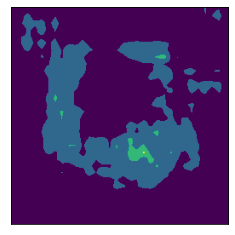

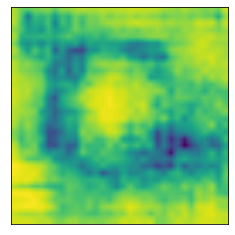

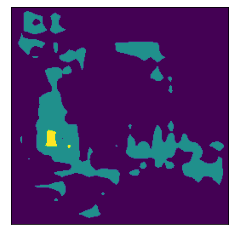

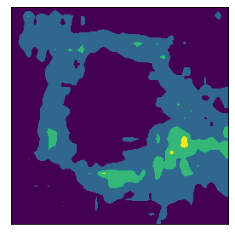

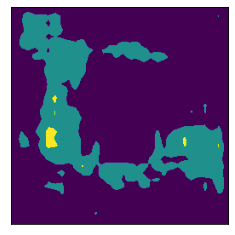

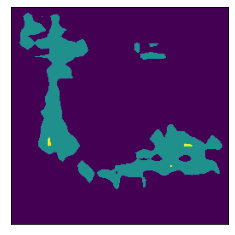

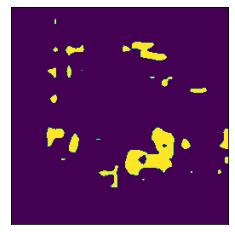

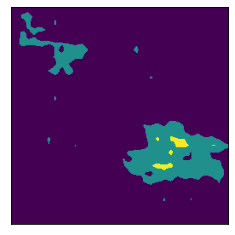

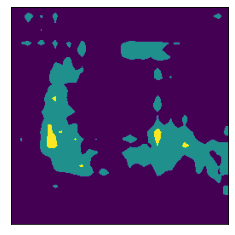

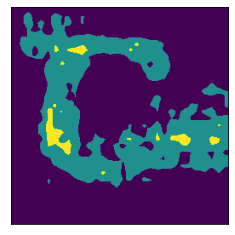

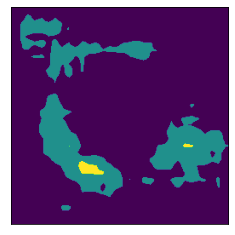

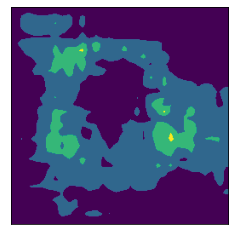

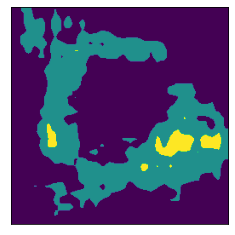

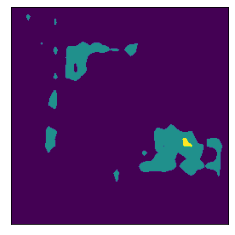

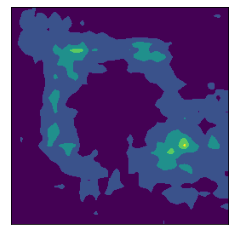

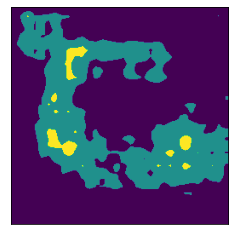

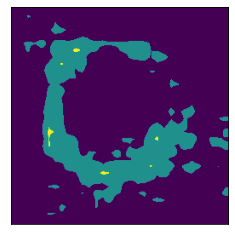

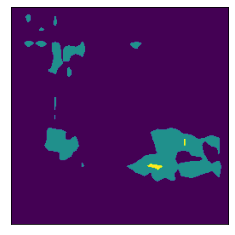

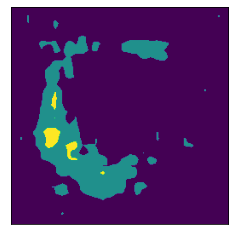

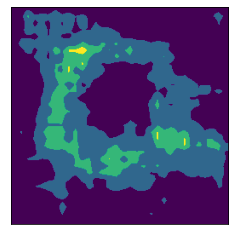

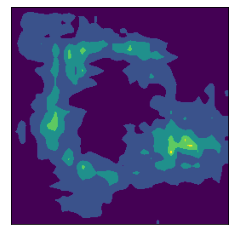

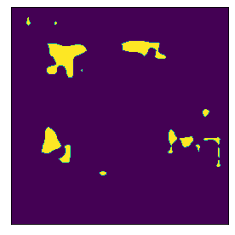

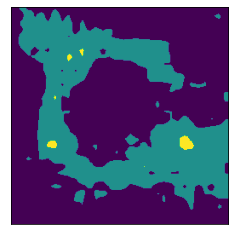

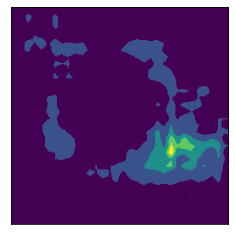

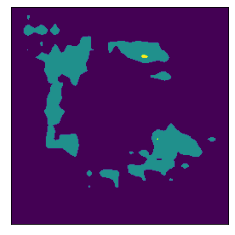

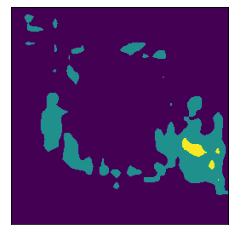

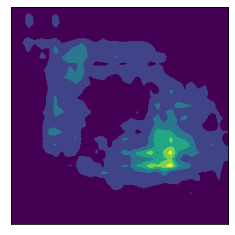

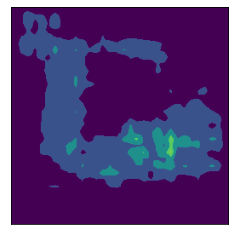

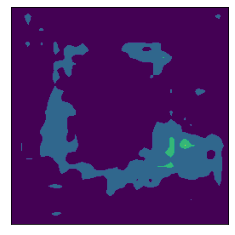

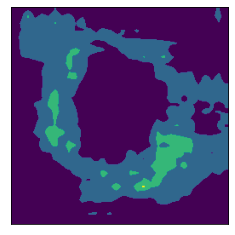

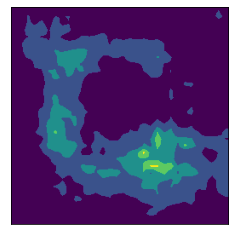

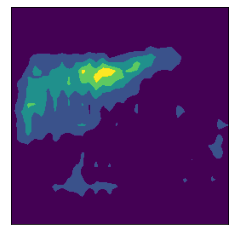

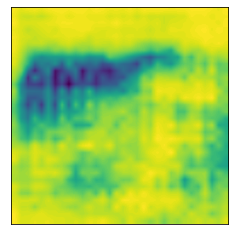

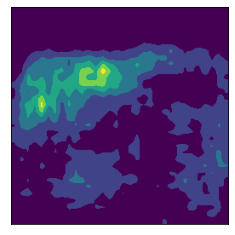

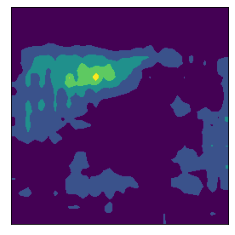

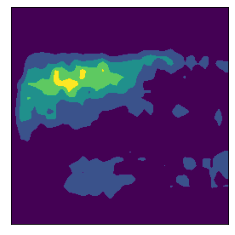

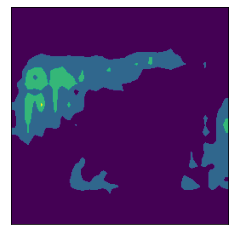

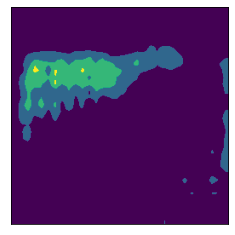

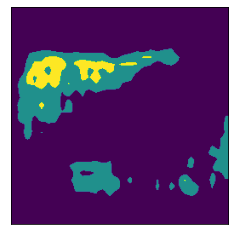

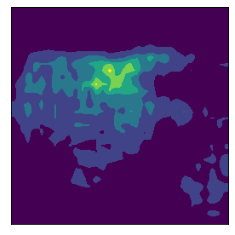

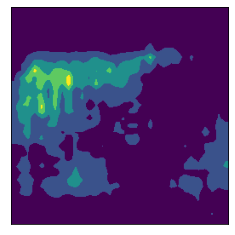

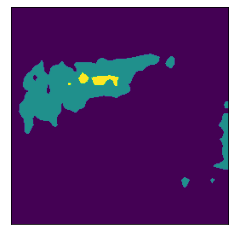

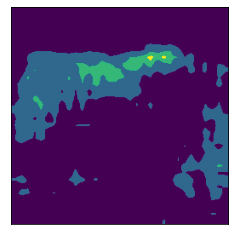

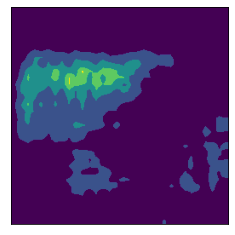

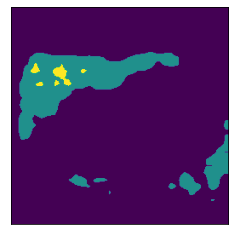

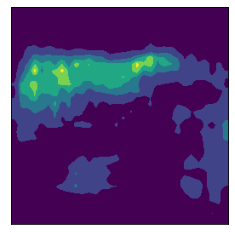

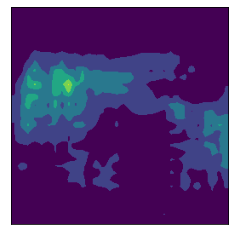

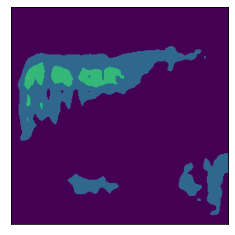

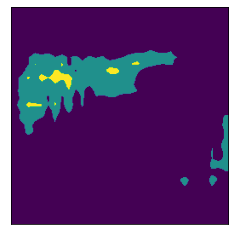

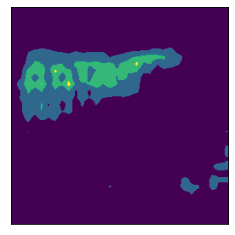

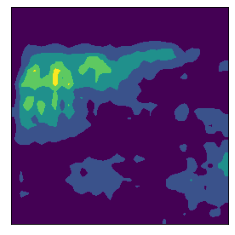

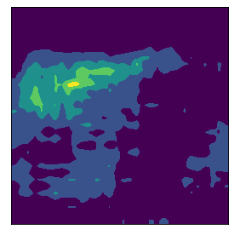

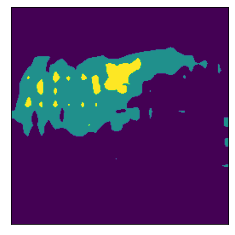

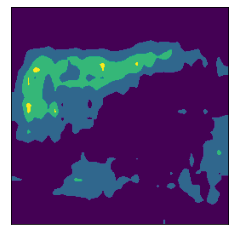

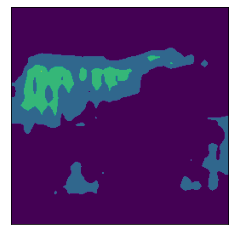

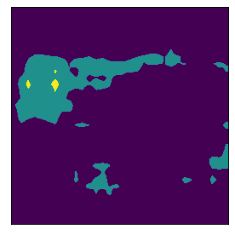

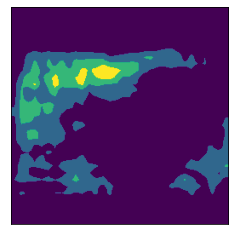

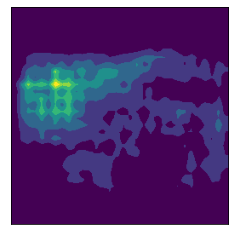

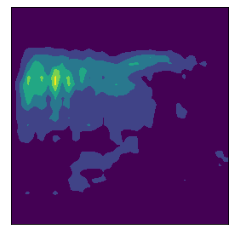

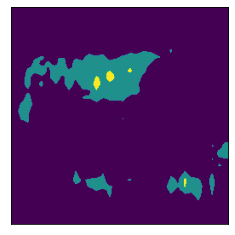

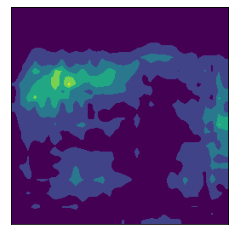

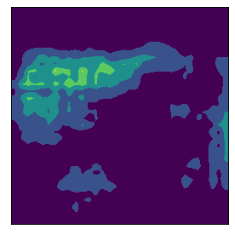

In [16]:

import matplotlib.pyplot as plt
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img2 = (img>0.5).float()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
i = 0        
for mask in masks:
#     print(i)
    show(mask)
    i=i+1

In [113]:
# from PIL import Image
# import torchvision.transforms as T
# transform = T.ToPILImage(mode = np.dtype(float))
# img = npred
# # img = torch.argmax(npred.squeeze(),dim=1)
# print(img.size())
# print(img[0].max())
# image = transform(img[0])
# new_im = ((npred - npred.min()) * (1/(npred.max() - npred.min()) * 255))
# new_im.max()
# image = transform(new_im)

In [ ]:
# image

In [ ]:
transform = T.ToPILImage()
image = transform(batch[1])
image

In [ ]:
x